In [1]:
import tensorflow as tf
import os
import random
import shutil
from shutil import copyfile
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop

print(tf.__version__)
tf.test.gpu_device_name()

2.2.0-dlenv


''

In [2]:
try:
    #YOUR CODE GOES HERE
    main_dir = "/home/kagmeth/face-mask-prj/datasets"
    
    train_dir = os.path.join(main_dir, "training")
    test_dir = os.path.join(main_dir, "testing")
    
    MASK_train = os.path.join(train_dir, "mask")
    NOMASK_train = os.path.join(train_dir, "nomask")
    
    MASK_test = os.path.join(test_dir, "mask")
    NOMASK_test = os.path.join(test_dir, "nomask")
    
#     os.mkdir(main_dir)
    
#     os.mkdir(train_dir)
#     os.mkdir(test_dir)
    
#     os.mkdir(cats_train)
#     os.mkdir(dogs_train)
    
#     os.mkdir(cats_test)
#     os.mkdir(dogs_test)
    
except OSError:
    print("Error")
    pass

In [21]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    data = os.listdir(SOURCE)
    data = random.sample(data, len(data)) # shuffled
    for count, file in enumerate(data):
        if(count < SPLIT_SIZE * len(data)) and os.path.getsize(f"{SOURCE}/{file}")!=0:
            copyfile(f"{SOURCE}/{file}", f"{TRAINING}/{file}")
        elif (count >= SPLIT_SIZE * len(data)) and os.path.getsize(f"{SOURCE}/{file}")!=0:
            copyfile(f"{SOURCE}/{file}", f"{TESTING}/{file}")

MASK_SOURCE_DIR = "/home/kagmeth/face-mask-prj/dataset/with_mask"
TRAINING_MASK_DIR = "/home/kagmeth/face-mask-prj/datasets/training/mask"
TESTING_MASK_DIR = "/home/kagmeth/face-mask-prj/datasets/testing/mask"
NOMASK_SOURCE_DIR = "/home/kagmeth/face-mask-prj/dataset/without_mask"
TRAINING_NOMASK_DIR = "/home/kagmeth/face-mask-prj/datasets/training/nomask"
TESTING_NOMASK_DIR = "/home/kagmeth/face-mask-prj/datasets/testing/nomask"

split_size = .8
split_data(MASK_SOURCE_DIR, TRAINING_MASK_DIR, TESTING_MASK_DIR, split_size)
split_data(NOMASK_SOURCE_DIR, TRAINING_NOMASK_DIR, TESTING_NOMASK_DIR, split_size)

In [3]:
print(len(os.listdir('/home/kagmeth/face-mask-prj/datasets/training/mask')))
print(len(os.listdir('/home/kagmeth/face-mask-prj/datasets/testing/mask')))
print(len(os.listdir('/home/kagmeth/face-mask-prj/datasets/training/nomask')))
print(len(os.listdir('/home/kagmeth/face-mask-prj/datasets/testing/nomask')))

# Expected output:
# 1533
# 383
# 1544
# 386

1533
383
1544
386


In [11]:
TRAINING_DIR = train_dir
train_datagen = ImageDataGenerator(rescale=1./255)

# TRAIN GENERATOR.
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150, 150),
    batch_size=10,
    class_mode='binary'
)

VALIDATION_DIR = test_dir
validation_datagen = ImageDataGenerator(rescale = 1./255)

# VALIDATION GENERATOR.
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150,150),
    batch_size=10,
    class_mode='binary')

Found 3077 images belonging to 2 classes.
Found 769 images belonging to 2 classes.


In [16]:
model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
tf.keras.layers.MaxPooling2D(2, 2),
tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
tf.keras.layers.MaxPooling2D(2, 2),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
tf.keras.layers.MaxPooling2D(2, 2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(512, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [17]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 64)       

In [18]:
history = model.fit(train_generator,
                      epochs=10,
                      verbose=1,
                      validation_data=validation_generator)

Epoch 1/10
218/308 [====================>.........] - ETA: 7s - loss: 0.6061 - acc: 0.8071

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


308/308 [==============================] - 31s 100ms/step - loss: 0.5049 - acc: 0.8385 - val_loss: 0.9357 - val_acc: 0.6385
Epoch 2/10
308/308 [==============================] - 31s 100ms/step - loss: 0.2600 - acc: 0.9139 - val_loss: 0.1824 - val_acc: 0.9363
Epoch 3/10
308/308 [==============================] - 31s 99ms/step - loss: 0.1964 - acc: 0.9360 - val_loss: 0.2134 - val_acc: 0.9350
Epoch 4/10
308/308 [==============================] - 30s 99ms/step - loss: 0.1681 - acc: 0.9425 - val_loss: 0.2441 - val_acc: 0.9246
Epoch 5/10
308/308 [==============================] - 31s 99ms/step - loss: 0.1492 - acc: 0.9545 - val_loss: 0.1506 - val_acc: 0.9532
Epoch 6/10
308/308 [==============================] - 30s 99ms/step - loss: 0.1388 - acc: 0.9594 - val_loss: 0.1482 - val_acc: 0.9441
Epoch 7/10
308/308 [==============================] - 31s 100ms/step - loss: 0.1179 - acc: 0.9626 - val_loss: 0.1203 - val_acc: 0.9584
Epoch 8/10
308/308 [==============================] - 31s 99ms/step - 

Text(0.5, 1.0, 'Training and validation loss')

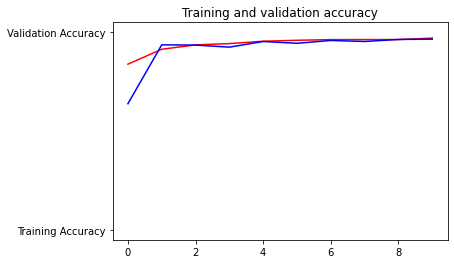

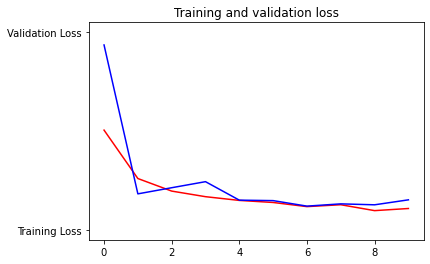

In [19]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)